# Import Libraries

##### Import Scientific Libraries 

In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.fft import fft, fftfreq, ifft, fftshift, ifftshift

### Below are OPTIONAL for this notebook

# import matplotlib.dates as mdates
# import matplotlib.ticker as ticker
# from datetime import datetime
# from datetime import timedelta
# from scipy import interpolate
import glob
# import time
# from scipy.fft import fft, fftfreq, ifft

##### Import NASA CDF Library (in case *.cdf is imported)

In [7]:
# import os
# os.environ["CDF_LIB"] = "/home/local/cdf/lib/"
# from spacepy import pycdf

##### Import plasmaKU library for ease of use

In [8]:
import plasmaKU as ku

# Import Files to Pandas Dataframe

In [20]:
'''
Below are the code to FIND CSV files named as dfi_raw_iRes.csv, where i is MMS number. 
The files should be in ../DataFrame/08Sep2015/ directory.
The process below is to get Pandas Dataframe for all MMS and sort the indices into variable df0.
Also, the time in the data is already converted from string into datetime variables.
The dataframes are in the list `df0`
'''

dates = '08Sep2015'
path='../DataFrame/'

files = glob.glob(path+"df*.csv")
file = []
mms = []
for i in range(len(files)):
    for j in range(1,5):
        if files[i] == str(path)+"df"+str(j)+"_raw_iRes.csv":
            mms.append(j)
            file.append(files[i])
df0 = []
for i in range(len(file)):
    df0.append(pd.read_csv(file[i]))
for i in range(len(df0)):
    df0[i]['epoch'] = ku.readtime1(df0[i]['epoch'])

sorted_mms = sorted(mms)
index = []
for i in sorted_mms:
    index.append(mms.index(i))
dfs = []
for i in index:
    dfs.append(df0[i])
df0 = dfs
mms = sorted_mms

# Get data into list of 4 MMS

`t`  = time \
`e`  = electric field [unit: mV/m] \
`b`  = magnetic field [unit: nT]\
`ui` = ion bulk velocity [unit: km/s]\
`ue` = electron bulk velocity [unit: km/s]\
`ji` = ion current denisty [unit: A/m^2]\
`je` = electron current denisty [unit: A/m^2]

Note that `ji`, `je`, `e` have "parallel" and "perpendicular" components labeled as `ji_para` or `ji_perp` for example

In [21]:
t = []
e = []
b = []
ui = []
ue = []
n = []

for i in range(len(df0)):
    t.append(df0[i]['epoch'].values)
    e.append(df0[i][['ex_notnan'+str(mms[i]),'ey_notnan'+str(mms[i]),'ez_notnan'+str(mms[i])]].values)
    b.append(df0[i][['bx'+str(mms[i]),'by'+str(mms[i]),'bz'+str(mms[i])]].values)
    ui.append(df0[i][['uix'+str(mms[i]),'uiy'+str(mms[i]),'uiz'+str(mms[i])]].values)
    ue.append(df0[i][['uex'+str(mms[i]),'uey'+str(mms[i]),'uez'+str(mms[i])]].values)
    n.append(df0[i][['ne'+str(mms[i])]].values)

In [22]:
q = 1.60217663e-19
ji = [[],[],[],[]]
je = [[],[],[],[]]
b_mag = []
b_unit = [[],[],[],[]]
for i in range(len(df0)):
    b_mag.append(np.linalg.norm(b[i], axis=1))
    
    for j in range(len(df0[i])):
        ji[i].append(q*n[i][:][j]*ui[i][j]*1e9)
        je[i].append(-q*n[i][:][j]*ue[i][j]*1e9)
        b_unit[i].append(b[i][j]/b_mag[i][j])
        
    ji[i] = np.array(ji[i])
    je[i] = np.array(je[i])
    b_unit[i] = np.array(b_unit[i])

In [23]:
ji_para = [[],[],[],[]]
je_para = [[],[],[],[]]
e_para = [[],[],[],[]]
ji_perp = [[],[],[],[]]
je_perp = [[],[],[],[]]
e_perp = [[],[],[],[]]
for i in range(len(df0)):
    for j in range(len(df0[i])):
        ji_para[i].append(np.dot(ji[i][j],b_unit[i][j])*b_unit[i][j])
        je_para[i].append(np.dot(je[i][j],b_unit[i][j])*b_unit[i][j])
        e_para[i].append(np.dot(e[i][j],b_unit[i][j])*b_unit[i][j])
    ji_para[i] = np.array(ji_para[i])
    je_para[i] = np.array(je_para[i])
    e_para[i] = np.array(e_para[i])
for i in range(len(df0)):
    for j in range(len(df0[i])):
        ji_perp[i].append(ji[i][j] - ji_para[i][j])
        je_perp[i].append(je[i][j] - je_para[i][j])
        e_perp[i].append(e[i][j] - e_para[i][j])
    ji_perp[i] = np.array(ji_perp[i])
    je_perp[i] = np.array(je_perp[i])
    e_perp[i] = np.array(e_perp[i])

# Fourier Analysis

Do fast-fourier transform using `fft` and `fftshift` (see [fft](https://docs.scipy.org/doc/scipy/reference/generated/scipy.fft.fft.html#scipy.fft.fft) and [fftshift](https://docs.scipy.org/doc/scipy/reference/generated/scipy.fft.fftshift.html))
and get the frequency using `fftfreq` (see [fftfreq](https://docs.scipy.org/doc/scipy/reference/generated/scipy.fft.fftfreq.html#scipy.fft.fftfreq))

In [24]:
ji_paraxf = []
ji_parayf = []
ji_parazf = []
je_paraxf = []
je_parayf = []
je_parazf = []

e_paraxf = []
e_parayf = []
e_parazf = []

ji_perpxf = []
ji_perpyf = []
ji_perpzf = []
je_perpxf = []
je_perpyf = []
je_perpzf = []

e_perpxf = []
e_perpyf = []
e_perpzf = []

f = []

for i in range(len(mms)):
    ji_paraxf.append(fftshift(fft(ji_para[i][:,0]))/len(df0[i]))
    ji_parayf.append(fftshift(fft(ji_para[i][:,1]))/len(df0[i]))
    ji_parazf.append(fftshift(fft(ji_para[i][:,2]))/len(df0[i]))
    je_paraxf.append(fftshift(fft(je_para[i][:,0]))/len(df0[i]))
    je_parayf.append(fftshift(fft(je_para[i][:,1]))/len(df0[i]))
    je_parazf.append(fftshift(fft(je_para[i][:,2]))/len(df0[i]))

    e_paraxf.append(fftshift(fft(e_para[i][:,0]))/len(df0[i]))
    e_parayf.append(fftshift(fft(e_para[i][:,1]))/len(df0[i]))
    e_parazf.append(fftshift(fft(e_para[i][:,2]))/len(df0[i]))

    ji_perpxf.append(fftshift(fft(ji_perp[i][:,0]))/len(df0[i]))
    ji_perpyf.append(fftshift(fft(ji_perp[i][:,1]))/len(df0[i]))
    ji_perpzf.append(fftshift(fft(ji_perp[i][:,2]))/len(df0[i]))
    je_perpxf.append(fftshift(fft(je_perp[i][:,0]))/len(df0[i]))
    je_perpyf.append(fftshift(fft(je_perp[i][:,1]))/len(df0[i]))
    je_perpzf.append(fftshift(fft(je_perp[i][:,2]))/len(df0[i]))

    e_perpxf.append(fftshift(fft(e_perp[i][:,0]))/len(df0[i]))
    e_perpyf.append(fftshift(fft(e_perp[i][:,1]))/len(df0[i]))
    e_perpzf.append(fftshift(fft(e_perp[i][:,2]))/len(df0[i]))
    
    f.append(fftshift(fftfreq(len(df0[i]), d=0.03)))

Do the dot product in Fourier space

In [25]:
JidotEf_para = []
JedotEf_para = []
JidotEf_perp = []
JedotEf_perp = []

for i in range(len(mms)):
    JidotEf_para.append(np.real((ji_paraxf[i]*np.conjugate(e_paraxf[i]) + ji_parayf[i]*np.conjugate(e_parayf[i]) + ji_parazf[i]*np.conjugate(e_parazf[i])))*1e6)
    JedotEf_para.append(np.real((je_paraxf[i]*np.conjugate(e_paraxf[i]) + je_parayf[i]*np.conjugate(e_parayf[i]) + je_parazf[i]*np.conjugate(e_parazf[i])))*1e6)
    JidotEf_perp.append(np.real((ji_perpxf[i]*np.conjugate(e_perpxf[i]) + ji_perpyf[i]*np.conjugate(e_perpyf[i]) + ji_perpzf[i]*np.conjugate(e_perpzf[i])))*1e6)
    JedotEf_perp.append(np.real((je_perpxf[i]*np.conjugate(e_perpxf[i]) + je_perpyf[i]*np.conjugate(e_perpyf[i]) + je_perpzf[i]*np.conjugate(e_perpzf[i])))*1e6)

Create dataframe `dff` to store $\mathbf{J}\cdot\mathbf{E}$ for each (positive) frequency

In [26]:
dff  = [pd.DataFrame(), pd.DataFrame(), pd.DataFrame(), pd.DataFrame()]
for i in range(len(mms)):
    dff[i]['f'] = -f[i][:int(len(f[i])/2)]
    dff[i]['JidotEf_para'+str(mms[i])] = JidotEf_para[i][:int(len(f[i])/2)]*2
    dff[i]['JedotEf_para'+str(mms[i])] = JedotEf_para[i][:int(len(f[i])/2)]*2
    dff[i]['JidotEf_perp'+str(mms[i])] = JidotEf_perp[i][:int(len(f[i])/2)]*2
    dff[i]['JedotEf_perp'+str(mms[i])] = JedotEf_perp[i][:int(len(f[i])/2)]*2

Add zero frequency to the dataframe `dff`

In [27]:
for i in range(len(mms)):
    addrow = pd.DataFrame()
    addrow['f'] = f[i][int(len(f[i])/2):int(len(f[i])/2)+1]
    addrow['JidotEf_para'+str(mms[i])] = JidotEf_para[i][int(len(f[i])/2)]
    addrow['JedotEf_para'+str(mms[i])] = JedotEf_para[i][int(len(f[i])/2)]
    addrow['JidotEf_perp'+str(mms[i])] = JidotEf_perp[i][int(len(f[i])/2)]
    addrow['JedotEf_perp'+str(mms[i])] = JedotEf_perp[i][int(len(f[i])/2)]
    dff[i] = pd.concat([dff[i], addrow], ignore_index=True)
    addrow
    
    if len(f[i])%2 == 0:
        # print('cut first freq...')
        dff[i] = dff[i][1:].reset_index(drop=True)
    dff[i] = dff[i].sort_values(by='f').reset_index(drop=True)

In [34]:
logscale = np.logspace(-4,np.log10(1.5), num=40)*2
logscale1 = np.logspace(-4,np.log10(17), num=40)
logscale = logscale1

JEfi_para = []
JEfe_para = []
JEfi_perp = []
JEfe_perp = []

for j in range(len(mms)):
    JEfi_para0 = []
    JEfe_para0 = []
    JEfi_perp0 = []
    JEfe_perp0 = []

    for i in range(len(logscale)+1):
        if i == 0:
            val  = dff[j][dff[j]['f'] <= logscale[0]][['JedotEf_para'+str(mms[j]),'JedotEf_perp'+str(mms[j]),'JidotEf_para'+str(mms[j]),'JidotEf_perp'+str(mms[j]),'f']]

        elif i == len(logscale):
            val  = dff[j][dff[j]['f'] >= logscale[-1]][['JedotEf_para'+str(mms[j]),'JedotEf_perp'+str(mms[j]),'JidotEf_para'+str(mms[j]),'JidotEf_perp'+str(mms[j]),'f']]

        else:
            val  = dff[j][(dff[j]['f'] >= logscale[i-1]) & (dff[j]['f'] < logscale[i])][['JedotEf_para'+str(mms[j]),'JedotEf_perp'+str(mms[j]),'JidotEf_para'+str(mms[j]),'JidotEf_perp'+str(mms[j]),'f']]

        if len(val) != 0:
            JEfi_para0.append(val.sum()['JidotEf_para'+str(mms[j])])
            JEfe_para0.append(val.sum()['JedotEf_para'+str(mms[j])])
            JEfi_perp0.append(val.sum()['JidotEf_perp'+str(mms[j])])
            JEfe_perp0.append(val.sum()['JedotEf_perp'+str(mms[j])])

        elif len(val) == 0:
            JEfi_para0.append(np.nan)
            JEfe_para0.append(np.nan)
            JEfi_perp0.append(np.nan)
            JEfe_perp0.append(np.nan)

    JEfi_para0 = np.array(JEfi_para0)
    JEfe_para0 = np.array(JEfe_para0)
    JEfi_perp0 = np.array(JEfi_perp0)
    JEfe_perp0 = np.array(JEfe_perp0)
    
    JEfi_para.append(JEfi_para0)
    JEfe_para.append(JEfe_para0)
    JEfi_perp.append(JEfi_perp0)
    JEfe_perp.append(JEfe_perp0)

In [35]:
dl = logscale[2]/logscale[1]
loglabel = np.append(logscale/np.sqrt(dl), logscale[-1]*np.sqrt(dl))

dl = logscale1[2]/logscale1[1]
loglabel1 = np.append(logscale1/np.sqrt(dl), logscale1[-1]*np.sqrt(dl))

# Plot

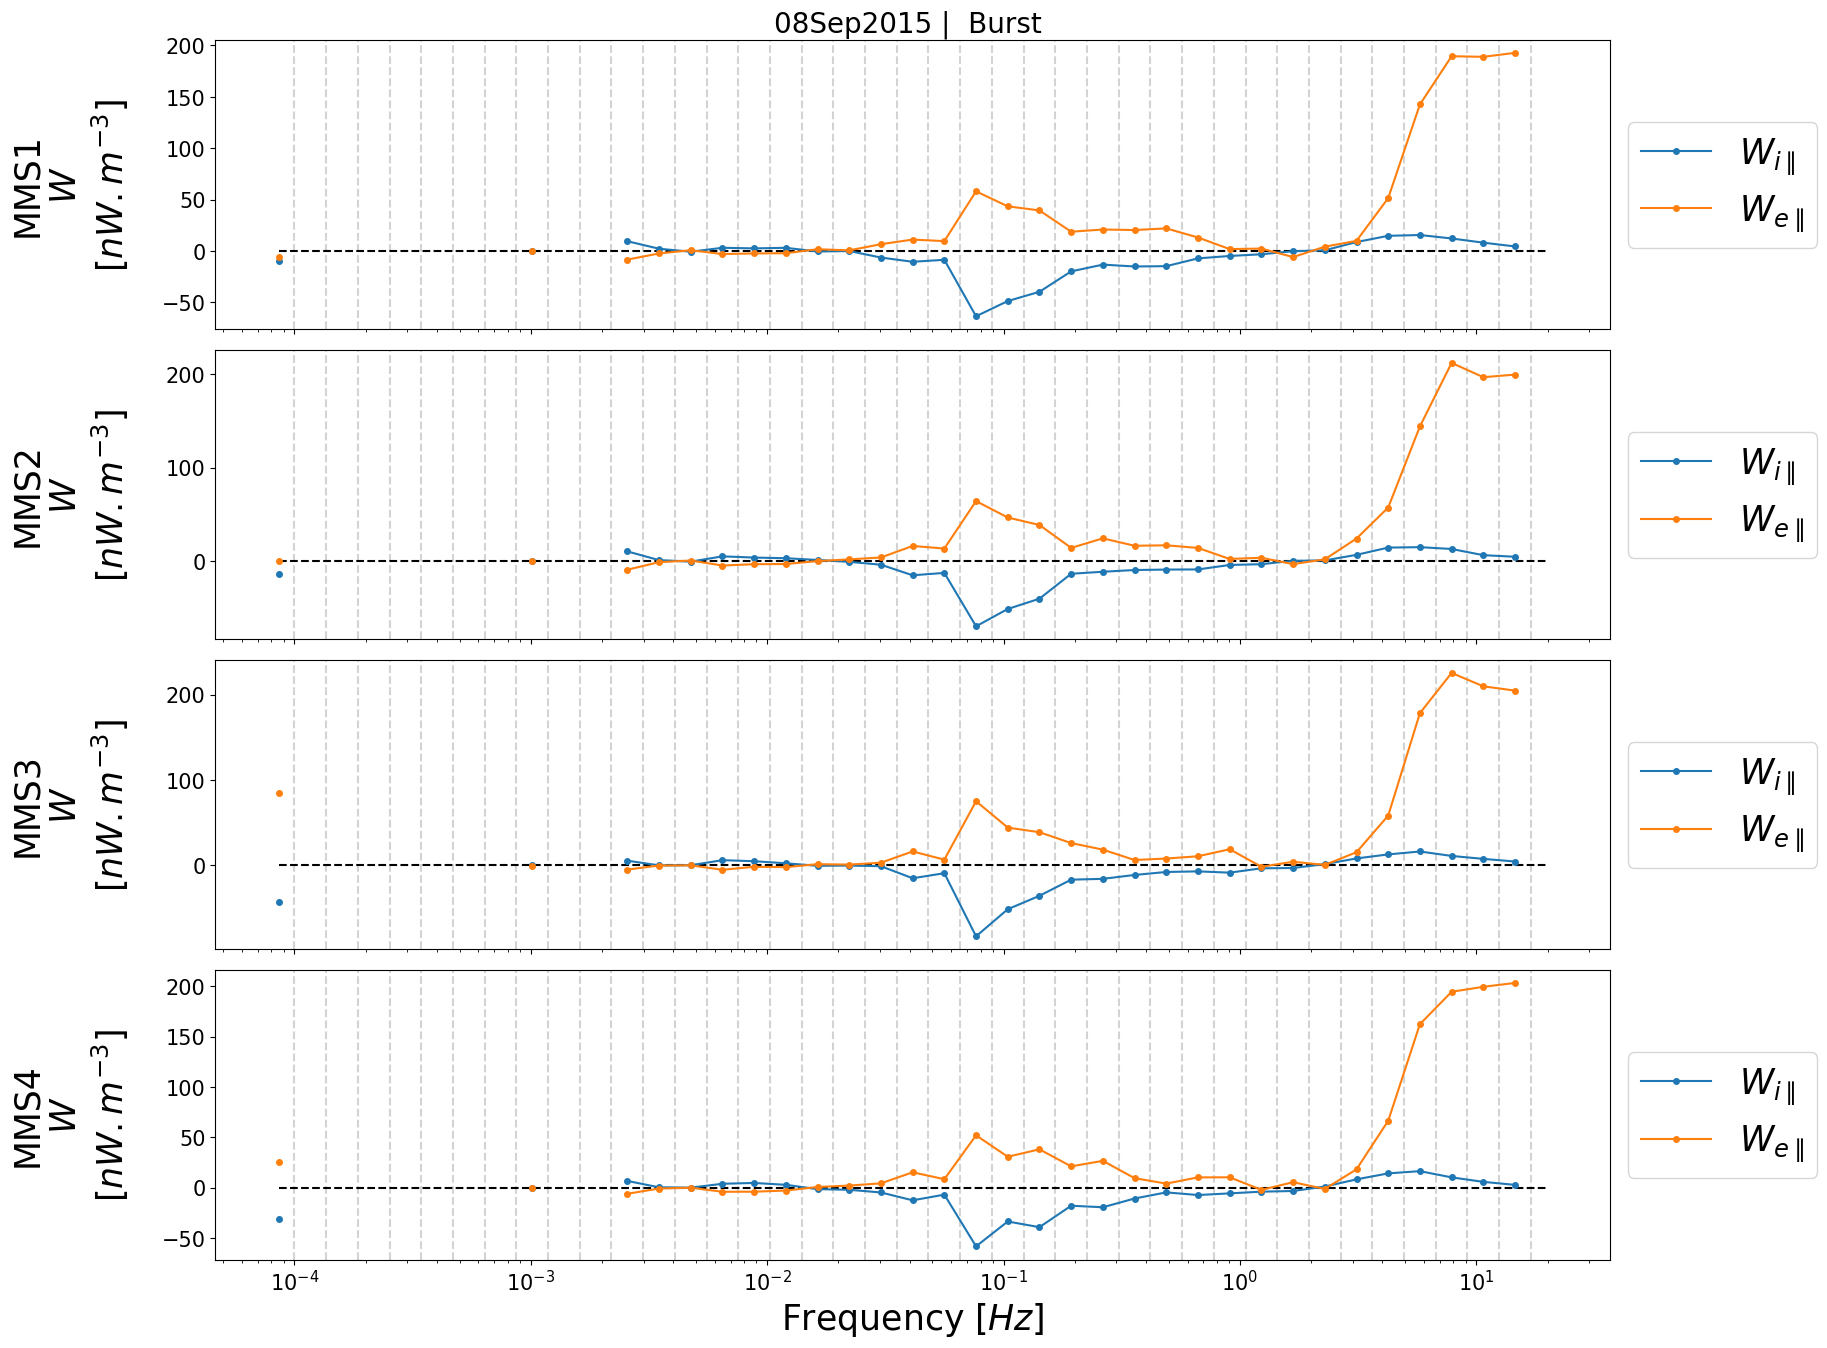

In [37]:
###### Make a plot #########
zeros = np.zeros(len(logscale)+1)
fig = plt.figure(figsize=(12,1))
plt.subplots_adjust(hspace=0.07)
s = 4

axs = []
for i in range(len(mms)):
    axs.append(fig.add_subplot(10,1,i+1))
    for j in range(len(logscale)):
        axs[i].axvline(x=logscale[j], color='lightgray', linestyle='--')
    axs[i].semilogx(loglabel, zeros, '--', c='k')
    axs[i].semilogx(loglabel, JEfi_para[i]*len(df0[i]), '-o', label=r'$W_{i\parallel}$', c='tab:blue', markersize=s)
    axs[i].semilogx(loglabel, JEfe_para[i]*len(df0[i]), '-o', label=r'$W_{e\parallel}$', c='tab:orange', markersize=s)
    # axs[i].semilogx(loglabel, JEfi_perp[i]*len(df0[i]), '-o', label=r'$W_{i\perp}$', c='tab:red', markersize=s)
    # axs[i].semilogx(loglabel, JEfe_perp[i]*len(df0[i]), '-o', label=r'$W_{e\perp}$', c='tab:green', markersize=s)
    axs[i].set_ylabel('MMS'+str(mms[i])+'\n'+r'$W$'+'\n'+r'$[nW.m^{-3}]$', fontsize=25)
    if i==3:
        axs[i].set_xlabel('Frequency '+r'$[Hz]$', fontsize=25)
    # axs[i].set_ylim(-15, 15)
axs[0].set_title(dates+' | '+' Burst ', fontsize=20)
for ax in axs[:-1]:
    plt.setp(ax.get_xticklabels(), visible=False)

for ax in axs:
    ax.legend(fontsize='25', bbox_to_anchor=(1, 0.5), loc='center left')
    ax.yaxis.set_label_coords(-0.06, 0.5)
    ax.tick_params(axis='both', which='major', labelsize=15)

ax = plt.gca()
ax.figure.set_size_inches(18,40)
# figname = 'JEFF.png'
# ax.figure.savefig(figname, dpi=500, bbox_inches='tight', pad_inches=0.2)
# print('Fig saved to ', figname)